In [1]:
import geopandas as gpd
from shapely.geometry import box
from pyproj import Transformer
import matplotlib.pyplot as plt

In [2]:
polygons = gpd.read_file("../data/raw/osm/wv_forest.geojson")
print("Original CRS:", polygons.crs)
polygons_3857 = polygons.to_crs(epsg=3857)
print("Reprojected CRS:", polygons_3857.crs)

Original CRS: EPSG:4326
Reprojected CRS: EPSG:3857


In [3]:

# Step 2: Define and reproject the bounding box
bbox_wgs84 = (-80.87501765, 37.54651655, -80.44783835, 37.79956715)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
west, south = transformer.transform(bbox_wgs84[0], bbox_wgs84[1])
east, north = transformer.transform(bbox_wgs84[2], bbox_wgs84[3])
bbox_geom = box(west, south, east, north)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:3857")

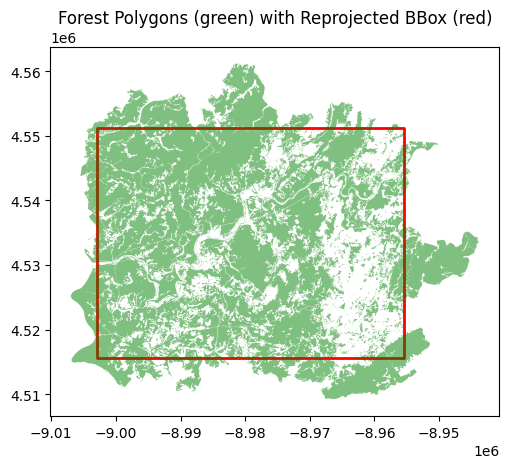

In [4]:
ax = bbox_gdf.plot(facecolor="none", edgecolor="red", linewidth=2)
polygons_3857.plot(ax=ax, color="green", alpha=0.5)
plt.title("Forest Polygons (green) with Reprojected BBox (red)")
plt.show()

In [5]:
intersecting = polygons_3857[polygons_3857.intersects(bbox_geom)]
print(f"{len(intersecting)} polygons intersect the bounding box.")

1871 polygons intersect the bounding box.


In [6]:
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np
from pathlib import Path

In [7]:
west_m, south_m, east_m, north_m = bbox_geom.bounds



In [8]:
resolution = 1.1943285668550503  # Try 10.0 or 30.0 for fast testing
width = int((east_m - west_m) / resolution)
height = int((north_m - south_m) / resolution)
transform = from_bounds(west_m, south_m, east_m, north_m, width, height)


In [9]:
geometries = [(geom, 1) for geom in intersecting.geometry if geom and geom.is_valid]

In [10]:
mask = rasterize(
    geometries,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=False,  # or True for more aggressive fill
)

In [11]:
print(f"Raster shape: {mask.shape}")
print(f"Nonzero pixels: {np.count_nonzero(mask)}")

Raster shape: (29798, 39815)
Nonzero pixels: 772991126


In [12]:
with rasterio.open(
    "../data/processed/masks/wv_mask_full.tif", "w",
    driver="GTiff",
    height=mask.shape[0],
    width=mask.shape[1],
    count=1,
    dtype="uint8",
    crs="EPSG:3857",
    transform=transform
) as dst:
    dst.write(mask, 1)